# Decoding neural activity
_Machine learning for mind reading_

This tutorial introduces concepts that are central to the practice of decoding neural activity using machine learning (or any method). We will make heavy use of our [Python package for neural decoding](https://github.com/KordingLab/Neural_Decoding).

This tutorial accompanies these [lecture slides](https://).

### Outline

1. Overfitting
2. Crossvalidation
3. Regularization
4. Applying recurrent neural networks
5. What methods work best and when?

## Preliminaries

Import modules and simulate data

### Let's simulate some data

In [1]:
import numpy as np
from matplotlib import pyplot as plt


In [2]:
# Generate some fake trial data
n_trials = 250
n_neurons = 10
n_bins_per_trial = 50

# And generate some fake neural recordings
# We'll pretend we have a drift diffusion model

def generate_neural_data(n_trials, n_neurons = 25, n_bins_per_trial = 50,
                         noise_variance = 1, drift_rate = 0.07,
                         mean_rate = 25):
  """Generates fake neural data of shape (n_trials, n_neurons, n_bins_per_trial
        according to a drift diffusion process with given parameters.
     Also generates decisions, which is 0 or 1 depending on the "animal's decision"
        and is returned as an array of shape (n_trials,)

    Returns: (neural_data, decisions)
  """

  decisions = np.random.binomial(1,.5,size = n_trials)

  neural_recordings = np.zeros((n_trials,n_neurons,n_bins_per_trial))

  for t in range(n_bins_per_trial):
    if t==0:
      neural_recordings[:,:,t] = mean_rate + np.random.randn(n_trials,n_neurons) * noise_variance
    else:
      neural_recordings[:,:,t] = neural_recordings[:,:,t-1] \
                      + np.reshape(drift_rate*(decisions*2-1),(len(decisions),1)) \
                      + np.random.randn(n_trials,n_neurons) * noise_variance

  return neural_recordings, decisions

neural_recordings, decisions = generate_neural_data(n_trials,
                                         n_neurons, n_bins_per_trial)

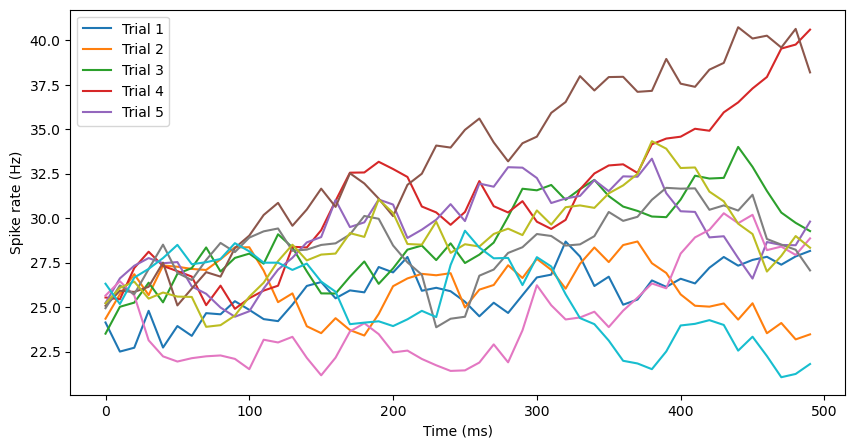

In [3]:
# plot out some trials for one neuron

neuron_id = 0

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,500,10),neural_recordings[:10,neuron_id,:].T)
plt.xlabel("Time (ms)")
plt.ylabel("Spike rate (Hz)")
plt.legend(["Trial {}".format(i) for i in range(1,6)])

#### Exercise 0: Look at the distribution of neural activity

Let's gain an intuition for the data. Plot out the average neural activity for each of the two choices.

Average across trials **and** neurons — we're going to assume they have the same response properties. Then, plot out the averages for trials with a choices of 0 vs a choice of 1.

If you have extra time, overlay the standard deviations.

Text(0, 0.5, 'Spike rate (Hz)')

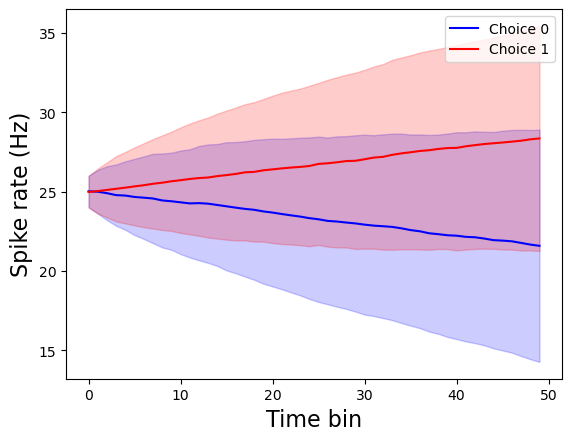

In [4]:
# Solution
means_0 = np.mean(neural_recordings[decisions==0], axis=(0,1))
means_1 = np.mean(neural_recordings[decisions==1], axis=(0,1))

plt.plot(means_0, c='b', label = "Choice 0")
plt.plot(means_1, c='r', label = "Choice 1")


# standard deviation overlay
stds_0 = np.std(neural_recordings[decisions==0], axis=(0,1))
stds_1 = np.std(neural_recordings[decisions==1], axis=(0,1))

plt.fill_between(range(50),means_0-stds_0, means_0+stds_0, color='b', alpha=.2)
plt.fill_between(range(50),means_1-stds_1, means_1+stds_1, color='r', alpha=.2)

plt.legend()
plt.xlabel("Time bin", fontsize = 16)
plt.ylabel("Spike rate (Hz)", fontsize = 16)


## 1. Overfitting

<img src='https://cdn-images-1.medium.com/max/1600/1*SBUK2QEfCP-zvJmKm14wGQ.png' />

In common parlance, we call a classifier or regressor 'overfit' when it has learned to explain noise in the training set at the expense of its ability to generalize to new data.

In that one-sentence description, we invoked the concepts of _training set_ and _generalization_. These are absolutely key to any modeling effort, including decoding.

##### Training sets vs. testing sets
You need to train your decoder, obviously, and for that you'll need training data. No one cares how well your decoder works on your training data, though. What we care about is its _performance on data not used for training_.  That is, we are interested in how well your decoder **generalizes** to new data. The only way to rigorously know how well your decoder generalizes is to test it on data not used for training.

In [5]:
from sklearn import linear_model

In [6]:
## Fit a decoder using all your data

# We'll predict each decision using all neurons's activity throughout the trials
X = np.reshape(neural_recordings, (n_trials,-1))

# initalize the model
my_naive_model = linear_model.LinearRegression()

#fit
my_naive_model.fit(X, decisions)

# And see how we did on our data set,
print("R2 was",my_naive_model.score(X,decisions))

R2 was 1.0


**Looks great!**

#### Exercise 1.1:
Now, suppose you release your decoder in the world. Will it work? Can't be better than perfect, right?

Create some new data and use the `score` function to see the $R^2$ of your model on new data.

In [7]:
# Let's do new electrophysiology and take new data. This cost $2,000,000 in
# NIH funding so it better work.
new_neural_recordings, new_decisions = generate_neural_data(n_trials,
                                             n_neurons, n_bins_per_trial)
new_X = np.reshape(new_neural_recordings, (n_trials,-1))


# Now you: score the model on this new data

# solution:
print("R2 was",my_naive_model.score(new_X,new_decisions))

R2 was 0.049607852221279614


#### Exercise 1.2:
You may have noticed that we're using linear *regression*, even though we have a classification problem.
It'd be better to use logistic regression.

Fit and score this logistic regression method using your original data.

Then, also score this method with the new data you just obtained with your R01 funds. (That is, print both the test and train accuracy.)

In [8]:
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)

#solution
log_reg.fit(X, decisions)
print("Train accuracy was",log_reg.score(X,decisions))
print("Test accuracy was",log_reg.score(new_X,new_decisions))



Train accuracy was 1.0
Test accuracy was 0.876


c:\Users\malco\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Once you've completed that, just run this next cell.

It shows the coefficients of the fit you just made. Does it match your intuitions?

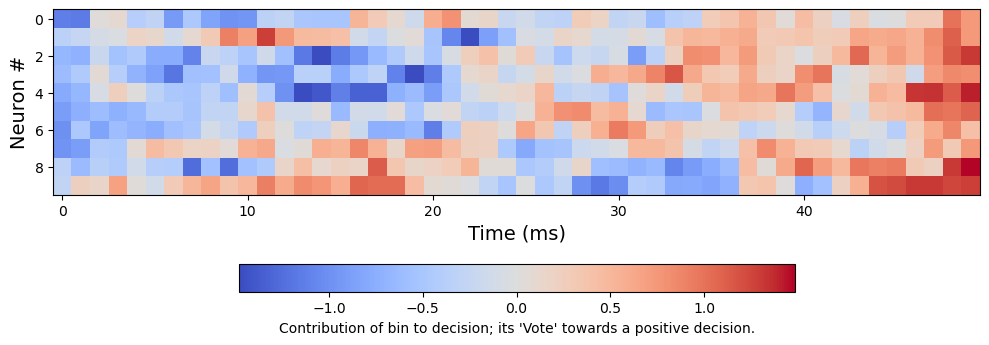

In [9]:

def plot_coefs(fit_model):
  """Makes a nice plot of the coefficients. fit_model is the model instance after fitting."""
  # get the coefficients of your fit
  coefficients = fit_model.coef_.reshape(n_neurons, n_bins_per_trial)

  # show them
  plt.figure(figsize = (10,5))
  plt.imshow(coefficients, cmap = 'coolwarm', vmin = -np.max(coefficients),
                                              vmax = np.max(coefficients))

  #make it pretty
  plt.ylabel("Neuron #", fontsize = 14)
  plt.xlabel("Time (ms)", fontsize = 14)
  plt.colorbar(orientation = 'horizontal', shrink = .6,
               label="Contribution of bin to decision; its 'Vote' towards a positive decision.")
  plt.tight_layout()
  plt.show()

plot_coefs(log_reg)

## 2. Crossvalidation

We saw in the last section that if we used all of our training data to fit a method, we have no idea how our method will work
on new data. This a problem for any engineering purpose.

We also have no idea if our coefficients are meaningful or reflect random noise in the data. This is a problem for the science.

The way to address this problem is to **split your data into a training segment and a validation segment**. We'll try an 80%/20% split.

In [10]:
split = int(n_trials*4/5)

training_data = X[:split]
validation_data = X[split:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

In [11]:
# fit on the training data
log_reg = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)

#solution
log_reg.fit(training_data, training_decisions)
print("Train accuracy was",log_reg.score(training_data,training_decisions))


Train accuracy was 1.0


c:\Users\malco\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [12]:
# score on the validation data
print("Test accuracy was",log_reg.score(validation_data,validation_decisions))

Test accuracy was 0.9


But right now we're only testing on 20% of the data! Small data means high variance, so maybe we can't trust these scores much.

A common practice is therefore to perform __k-fold crossvalidation__. This just means we rotate which segment of the original data is the validation set. We can then average the scores.

In [13]:
def get_test_train_splits(data, decisions, n_folds=5):
  """
  Returns a tuple of matched train sets and validation sets, rotating through the data.

  Note that there are scikit-learn functions that do this, too."""

  fold_size = len(data)//n_folds

  training_sets = [np.roll(data,fold_size*i, axis=0)[fold_size:] for i in range(n_folds)]
  val_sets = [np.roll(data,fold_size*i, axis=0)[:fold_size] for i in range(n_folds)]

  training_Y = [np.roll(decisions,fold_size*i, axis=0)[fold_size:] for i in range(n_folds)]
  val_Y = [np.roll(decisions,fold_size*i, axis=0)[:fold_size] for i in range(n_folds)]


  return (training_sets, training_Y), (val_sets, val_Y)




#### Excercise 2

Fill out the missing gaps in the script below.

How close is the validation accuracy to the test set accuracy?

How much did using 80% of the data affect the test set accuracy?

c:\Users\malco\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


   Validation accuracy of 0.9
   True test set accuracy of 0.872


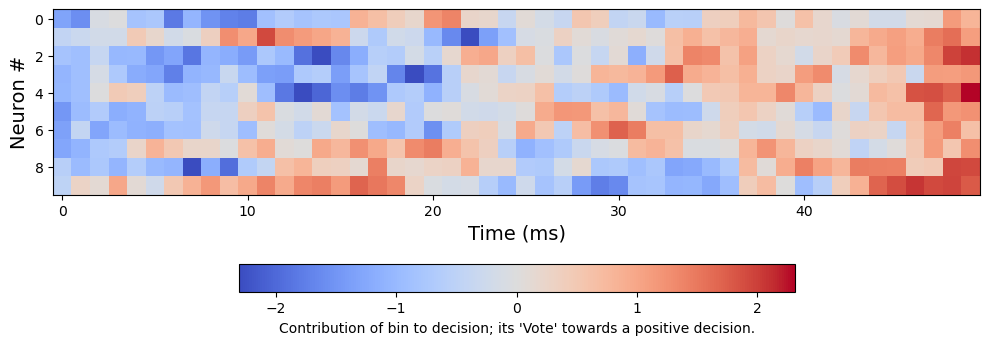

   Validation accuracy of 0.9
   True test set accuracy of 0.852


c:\Users\malco\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


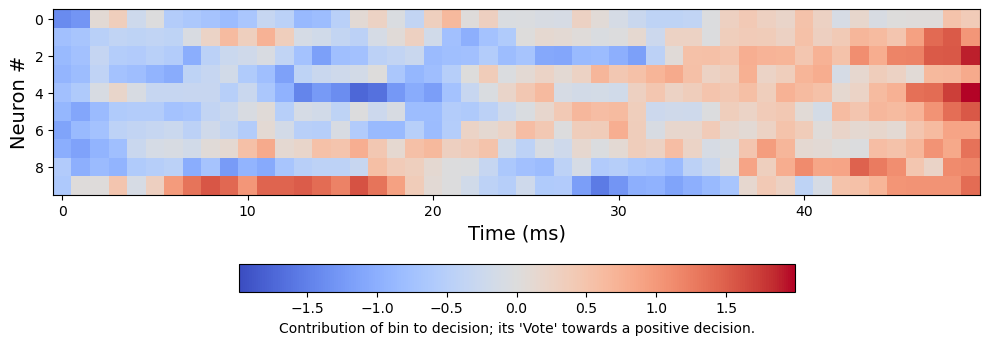

   Validation accuracy of 0.86
   True test set accuracy of 0.872


c:\Users\malco\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


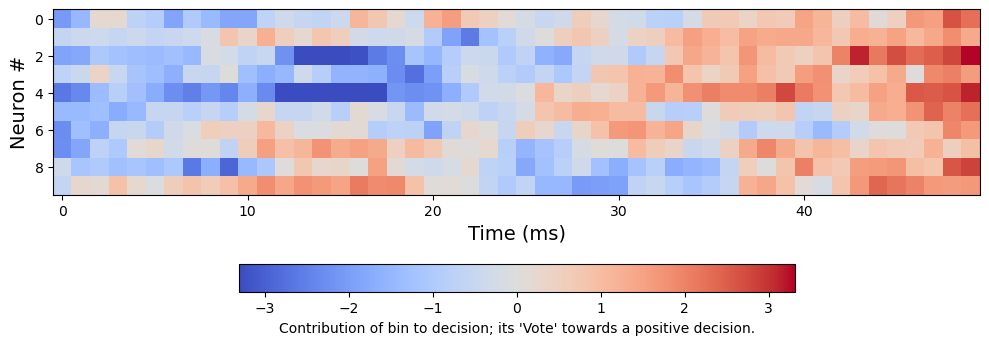

   Validation accuracy of 0.9
   True test set accuracy of 0.912


c:\Users\malco\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


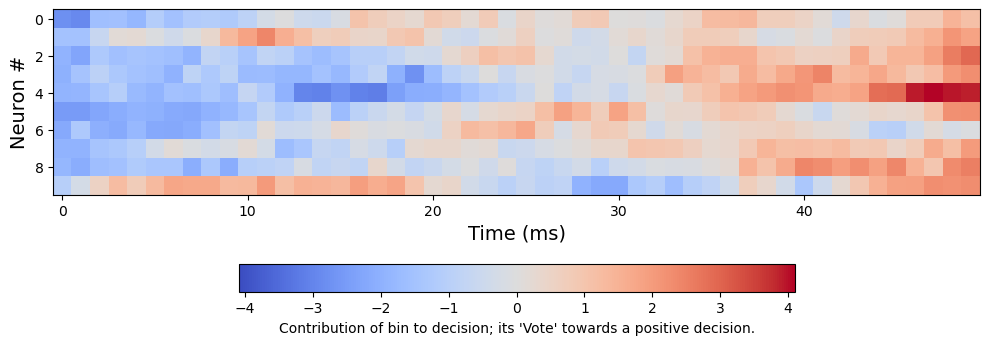

   Validation accuracy of 0.88
   True test set accuracy of 0.872


c:\Users\malco\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


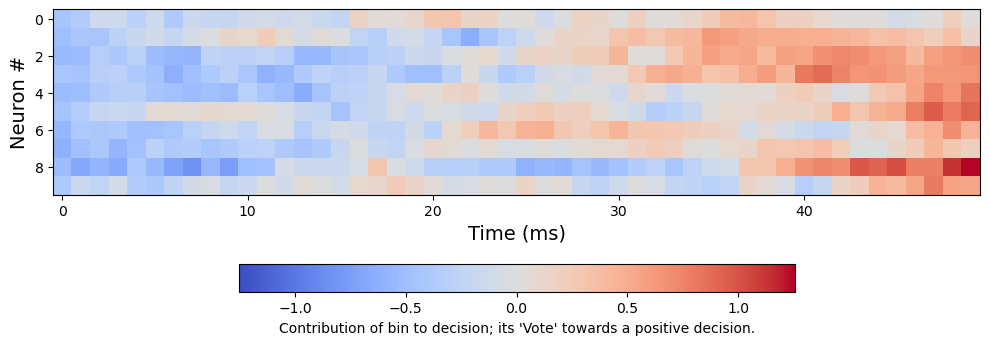

Mean validation accuracy: 0.8880000000000001


In [14]:
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []

# Iterate through the k=5 folds
for fold in range(5):

  training_X = training_sets[fold]
  training_Y = training_Ys[fold]

  validation_X = val_sets[fold]
  validation_Y = val_Ys[fold]

  # Redefine the logistic regression model. (important to do this inside the loop)
  this_model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs',
                                          max_iter = 1000)

  # Now fit on the training data
  this_model.fit(training_X, training_Y)

  # score on the validation data
  this_accuracy = this_model.score(validation_X, validation_Y)

  scores.append(this_accuracy)

  # score on the new dataset (new_X, new_decisions from above)
  accuracy_on_test_data = this_model.score(new_X, new_decisions)

  print("   Validation accuracy of {}".format( this_accuracy ))
  print("   True test set accuracy of {}".format( accuracy_on_test_data ))
  plot_coefs(this_model)

print("Mean validation accuracy: {}".format(np.mean(scores)))

## 3. Regularization

Here we'll apply regularization, as talked about in the lecture.


#### Exercise 3.1

Go to the [scikit-learn docs](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) and decide which form of regularization you would like to use with logistic regression.

#### Exercise 3.2

Copy and paste the cell from _Excercise 2_, but this time change the `penalty` flag in the `LogisticRegression` call to the form of regularization you chose.


First all other default parameters. Then set `C=1e-6` and see what happens.


   Validation accuracy of 0.58
   True test set accuracy of 0.484


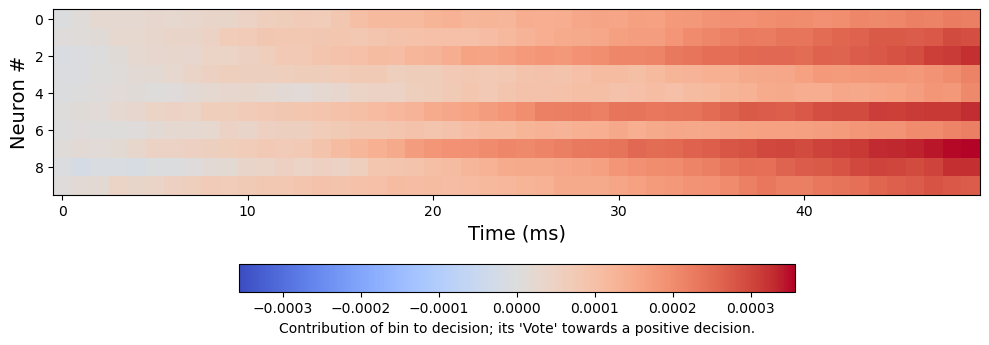

   Validation accuracy of 0.66
   True test set accuracy of 0.508


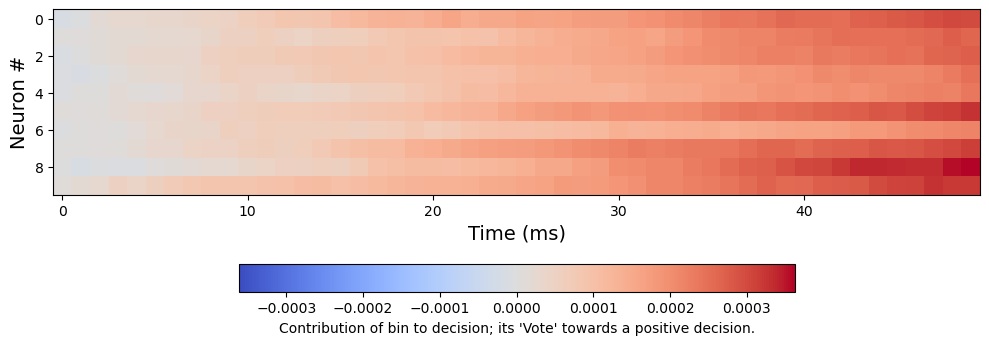

   Validation accuracy of 0.68
   True test set accuracy of 0.536


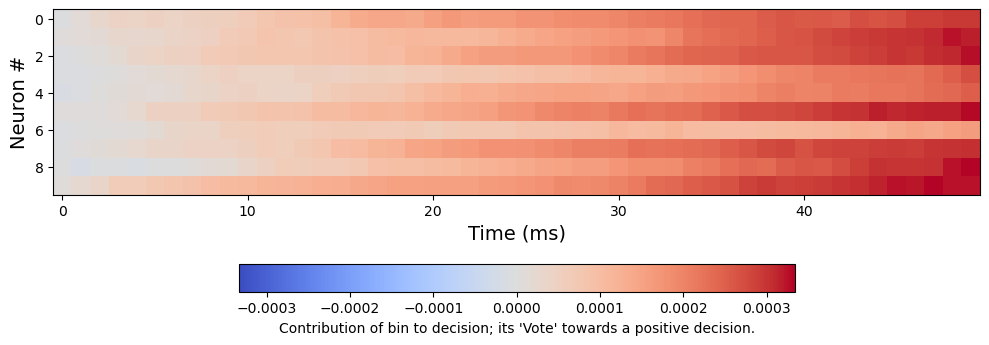

   Validation accuracy of 0.62
   True test set accuracy of 0.5


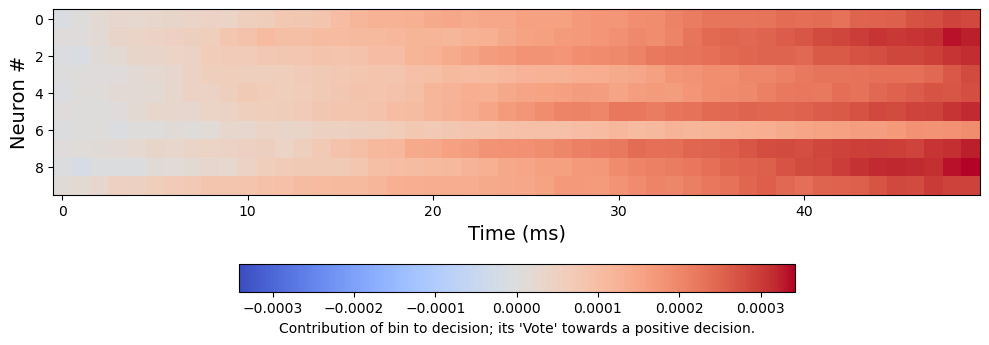

   Validation accuracy of 0.6
   True test set accuracy of 0.488


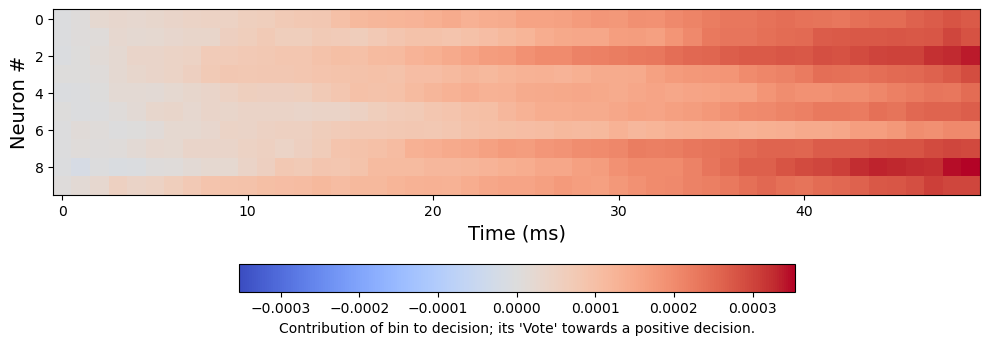

Mean validation accuracy: 0.628


In [15]:
# copy, paste, and regularize Exercise 2
(training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(X, decisions)

scores = []

# Iterate through the k=5 folds
for fold in range(5):

  training_X = training_sets[fold]
  training_Y = training_Ys[fold]

  validation_X = val_sets[fold]
  validation_Y = val_Ys[fold]

  # Redefine the logistic regression model. (important to do this inside the loop)
  this_model = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs',
                                          max_iter = 1000, C=1e-6)

  # Now fit on the training data
  this_model.fit(training_X, training_Y)

  # score on the validation data
  this_accuracy = this_model.score(validation_X, validation_Y)

  scores.append(this_accuracy)

  # score on the new dataset (new_X, new_decisions from above)
  accuracy_on_test_data = this_model.score(new_X, new_decisions)

  print("   Validation accuracy of {}".format( this_accuracy ))
  print("   True test set accuracy of {}".format( accuracy_on_test_data ))
  plot_coefs(this_model)

print("Mean validation accuracy: {}".format(np.mean(scores)))

#### Exercise 3.3: Choose the best regularization penalty

Let's automate the above process so that we can choose the best performing value of `C`.

First, write a function (largely copy and paste from the last exercise) that returns the mean validation accuracy for
an arbitrary value of `C`.

In [16]:
# First complete this function that takes data (e.g. X)
# and a model, and returns the average validation accuracy from 5-fold CV
def get_kfold_validation_score(data, decisions, C):


    # copy, paste, and regularize Exercise 2
  (training_sets, training_Ys), (val_sets, val_Ys) = get_test_train_splits(data, decisions)

  scores = []

  # Iterate through the k=5 folds
  for fold in range(5):

    training_X = training_sets[fold]
    training_Y = training_Ys[fold]

    validation_X = val_sets[fold]
    validation_Y = val_Ys[fold]

    # Redefine the logistic regression model. (important to do this inside the loop)
    this_model = linear_model.LogisticRegression(penalty='l2', solver = 'lbfgs',
                                            max_iter = 10000, C=C)

    # Now fit on the training data
    this_model.fit(training_X, training_Y)

    # score on the validation data
    this_accuracy = this_model.score(validation_X, validation_Y)

    scores.append(this_accuracy)

  mean_validation_accuracy  = np.mean(scores)
  return mean_validation_accuracy


Now let's create a loop for various values of `C` and see what's the best.


In [17]:

# decide on a logarithmic schedule of Cs.
Cs_to_test = np.logspace(5,-7,12)

validation_accuracy_vs_C = []
for C in Cs_to_test:

  # get the mean score on k-fold cross-validation using your function above
  mean_validation_accuracy = get_kfold_validation_score(X, decisions, C)

  validation_accuracy_vs_C.append(mean_validation_accuracy)


(0.8, 1.0)

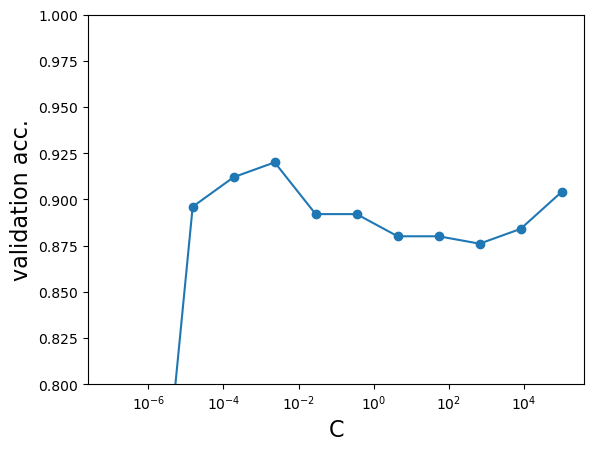

In [18]:
plt.semilogx(Cs_to_test, validation_accuracy_vs_C,"o-")
plt.xlabel("C",fontsize=16)
plt.ylabel("validation acc.",fontsize=16)
plt.ylim([.8,1])

## 4. Applying recurrent neural networks

This section is going to be a bit of an introduction to our [python package for neural decoding](https://github.com/KordingLab/Neural_Decoding).

First let's install the package. This will also install all the dependencies we need.

In [19]:
!pip install Neural-Decoding --upgrade

In [20]:
from Neural_Decoding  import decoders

import warnings
warnings.filterwarnings('ignore')


Keras version 2.14.0 is installed



In [21]:
!pip install Keras==1.2.2

  Using cached Keras-1.2.2-py3-none-any.whl
  Attempting uninstall: Keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 1.2.2 which is incompatible.


Let's take a look at the documentation of the decoder we'll use.

In [22]:
# Run me
?decoders.SimpleRNNClassification

Init signature:
decoders.SimpleRNNClassification(
    units=400,
    dropout=0,
    num_epochs=10,
    verbose=0,
)
Docstring:     
Class for the RNN decoder

Parameters
----------
units: integer, optional, default 400
    Number of hidden units in each layer

dropout: decimal, optional, default 0
    Proportion of units that get dropped out

num_epochs: integer, optional, default 10
    Number of epochs used for training

verbose: binary, optional, default=0
    Whether to show progress of the fit after each epoch
File:           c:\users\malco\anaconda3\lib\site-packages\neural_decoding\decoders.py
Type:           type
Subclasses:     

In [23]:
?decoders.SimpleRNNClassification.fit

Signature: decoders.SimpleRNNClassification.fit(self, X_train, y_train)
Docstring:
Train GRU Decoder

Parameters
----------
X_train: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
    This is the neural data.
    See example file for an example of how to format the neural data correctly

y_train: numpy 2d array of shape [n_samples, n_outputs]
    This is the outputs that are being predicted
File:      c:\users\malco\anaconda3\lib\site-packages\neural_decoding\decoders.py
Type:      function

You'll notice that the shape of the training inputs is now **3-dimensional**. This is because we can now explitly model the effect of time! Hooray!

Recall that recurrent neural networks contain a "hidden state". The way this decoder works is that it reads all the neural activities in at the first time bin (out of `n_time_bins`) and then updates its hidden state accordingly. The value of this hidden state informs how the hidden state will evolve over time in each trial. After the hidden state updates `n_time_bin` times, it outputs its prediction for the animal's choice.


Lets apply this classifier to the data.

In [24]:
# lets re-split our original 3-dimensional trials/neurons/time input data.
split = int(n_trials*4/5)

training_data = neural_recordings[:split]
validation_data = neural_recordings[split:]

training_decisions = decisions[:split]
validation_decisions = decisions[split:]

print("Training input data is of shape", training_data.shape)
print("Validation input data is of shape", validation_data.shape)


Training input data is of shape (200, 10, 50)
Validation input data is of shape (50, 10, 50)


In [25]:

# first we instantiate the decoder
my_RNN_classifier = decoders.SimpleRNNClassification(units = 50,
                                                    dropout = 0,
                                                    num_epochs =250,
                                                    verbose = 1)

In [29]:
# now we fit to our training data, like before

my_RNN_classifier.fit(training_data, training_decisions)

ModuleNotFoundError: No module named 'keras.api'

In [ ]:
# predict on the validation data

predictions = my_RNN_classifier.predict(validation_data)
predictions

AttributeError: 'SimpleRNNClassification' object has no attribute 'model'

##### Excercise 4.0

Get the percentage of the predictions that were made correctly.

In [ ]:
# solution
accuracy = np.sum(predictions == validation_decisions) / float(len(predictions))
print("{} %".format(100*accuracy))

This is not as quite as good as logistic regression yet. There are a lot of parameters to choose for RNNs, and we haven't tried that yet.


#### Looking inside the model

Within the `my_RNN_classifier` object you just fit, there is an actual Keras model. We can look at it, change its parameters, and use Keras methods.

In [ ]:
# Put the cursor after model, and press tab to see the methods we can call
my_RNN_classifier.model.

In [ ]:
# for example, we can use Keras's in-built method for calculating accuracy
from keras.utils import np_utils
acc = my_RNN_classifier.model.test_on_batch(validation_data,
                                      np_utils.to_categorical(validation_decisions))
print("Accuracy is {} %".format(100*acc[1]))

#### Excercise 4.1: Tuning the RNN

Train an RNN decoder again, but this time use 1000 hidden units instead of 50.

In [ ]:
my_RNN_classifier = decoders.SimpleRNNClassification(units = 1000,
                                                    dropout = 0,
                                                    num_epochs =250,
                                                    verbose = 0)
my_RNN_classifier.fit(training_data, training_decisions)
predictions = my_RNN_classifier.predict(validation_data)
accuracy = np.sum(predictions == validation_decisions) / float(len(predictions))
print("{} %".format(100*accuracy))

## 5. Compare many methods on actual neural data

### Preliminaries

Make sure you're running a GPU Colab for this section. (Runtime -> Change runtime type)

First we need to download the data. I created a script to download and process the Steinmetz data into the format we need. Since the processing script takes about 15 minutes, we'll skip that step, and you can just download the processed data from my Google Drive.

This dataset is specifically `Cori_2016-12-18`. If you're interested in loading a different session, I've copied my downloading and preprocessing script in the bottom of this notebook and you can run it right here.

In [ ]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1W3TwEtC0Z6Qmbfuz8_AWRiQHfuDb9FIS',
                                    dest_path='./Binned_data.zip',
                                    unzip=True)


In [ ]:
binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1


### Predicting choices from neural population recordings

We're going to try to predict the mouse's choices from the neuropixel recordings in the 1 second preceeding each choice. `binned_spikes.npy` is a numpy array containing the binned spike rates, and `choices.npy` contains the animal's choices.

There are 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).

This is not a great situation for machine learning. As a rule of thumb, we would like more trials than datapoints per trial. (If doing this for realz, would suggest running PCA on this data and using the top components as inputs). But, it's what we got, so here goes!

#### Exercise 5.0

Print out the shape of `binned_spikes` and `choices`. Also print out the first 10 choices.



In [ ]:

print(binned_spikes.shape, choices.shape)
print(choices[:10])

You'll notice that `choices` takes values 0, 1, and 2. We're going to try to decode this.

#### Excercise 5.1

Split this data into test and validation splits.

(We'll skip the final testing phase in this exercise. In reality, make sure to do cross-validation and use both validation and testing data.)

In [ ]:
# make training and validation data
# from binned_spikes and choices_1hot.
# Use an 80/20 split.|
split = int(len(binned_spikes)*4/5)

training_spikes = binned_spikes[:split]
validation_spikes = binned_spikes[split:]

training_choices = choices[:split]
validation_choices = choices[split:]

In [ ]:
training_spikes.shape

##### A fitting demo.

This is basically what we did above, but with actual data.

In [ ]:

my_RNN_classifier = decoders.SimpleRNNClassification(units = 100,
                                                    dropout = 0,
                                                    num_epochs =10,
                                                    verbose = 1)

my_RNN_classifier.fit(training_spikes, training_choices)


predictions = my_RNN_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))

print("\n validation accuracy: {} %".format(100*accuracy))


Note that the train accuracy reached about 100% in these 10 epochs, but the validation accuracy is quite low. Sounds like overfitting! We might want to try some regularization, like dropout.

### Excercise 5.1

Fit each of the following decoders:

1.   A Gated Recurrent Unit (`decoders.GRUClassification`)
2.   An LSTM (`decoders.LSTMClassification`)
3.   Gradient boosted trees (XGBoost) (`decoders.XGBoostClassification`)





In [ ]:
# GRU
GRU_classifier = decoders.GRUClassification(units = 100,
                                              dropout = .1,
                                              num_epochs =10,
                                              verbose = 1)

GRU_classifier.fit(training_spikes, training_choices)



predictions = GRU_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))
print("\n validation accuracy: {} %".format(100*accuracy))



In [ ]:
#LSTM
LSTM_classifier = decoders.LSTMClassification(units = 100,
                                                  dropout = 0,
                                                    num_epochs =100,
                                                    verbose = 1)

LSTM_classifier.fit(training_spikes, training_choices)


predictions = LSTM_classifier.predict(validation_spikes)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))
print("\n validation accuracy: {} %".format(100*accuracy))

In [ ]:
# XGBoost

# XGBoost is powerful but does not model time dependencies.
# Like for the logistic regression above, we have to flatten
# the inputs into shape (n_trials, n_neurons x n_time_bins)

flat_train_data = np.reshape(training_spikes, (len(training_spikes),-1))
flat_val_data = np.reshape(validation_spikes, (len(validation_spikes),-1))


# now we train
XGB_classifier = decoders.XGBoostClassification(gpu=0, num_round = 100,
                                       max_depth = 5, eta=0.01)

XGB_classifier.fit(flat_train_data, training_choices)

predictions = XGB_classifier.predict(flat_val_data)
accuracy = np.sum(predictions == validation_choices) / float(len(predictions))
print("{} %".format(100*accuracy))




### Extra credit exercise 1: reduce the dimension of data with PCA

Create an instance of PCA (loading the module from scikit-learn). Then, fit it on your training data. Then transform both the validation and train data. (Note that we don't fit the PCA using train data.)

You can either reduce the dimension across neurons only, preserving temporal structure, or decide to reduce across all dimensions.

Does validation accuracy improve?

### Extra credit exercise 2: Set up a script to perform k-fold CV

Using your favorite methods (e.g. scikit learn) or the script we wrote above, create a method to perform 5-fold cross-validation on the Neuropixels data. The function should take parameters to create a model as input, and it should output the average validation accuracy across the 5 validation sets.

### Extra credit exercise 3: find the best decoder

Search across methods and hyperparameters for the best decoder. Try hyperopt, or random searches.

If you're fancy and have lots of compute time, maybe try automated ML. (e.g. autosklearn)


## Appendix: downloading a Neuropixels session and processing

This will take about 30 seconds to download the ~600M of data into your working folder, and 10 minutes to run the script.

In [ ]:
session = "Cori_2016-12-14/"

!wget -np -r -nv http://data.cortexlab.net/taskData/$session
!mv data.cortexlab.net/taskData/ .

Now we'll extract this data into Python in the form of a dictionary.

In [ ]:
from tqdm import tqdm as tqdm

def load_data(session):
    """Takes a session in relative path ./taskData and loads it as a dictionary."""
    files = !ls taskData/$session/*.npy
    all_files = {}
    for file in files:
        filename = file.split("/")[2][:-4]
        all_files[filename] = np.load(file)
    return all_files

def count_neurons(time_interval, all_files):
    """In this time interval, return the neurons with nonzero spikes, and how many

    Returns (ids, counts)
    """


    t1,t2 = time_interval

    trial_spikes = all_files['spikes.times']

    interval = (trial_spikes > t1) & (trial_spikes < t2)

    trial_spikes = trial_spikes[interval]
    ids = all_files['spikes.clusters'][interval]

    # ids has all the info we need
    return np.unique(ids, return_counts = True)




def bin_into_array(all_files, time_before_response=1, n_bins = 50):

    ids = all_files['spikes.clusters']
    idList = np.unique(ids)

    n_trials = len(all_files['trials.response_choice'])
    n_neurons = len(idList)

    choices = np.reshape(all_files['trials.response_choice'],-1)
    data = np.zeros((n_trials, n_neurons, n_bins))

    time_resolution = time_before_response/ float(n_bins)
    print(time_resolution)

    for trial in tqdm(range(n_trials)):
        end_time = all_files['trials.response_times'][trial]
        start_time = end_time - time_before_response

        print(time_resolution)

        for b in range(n_bins):

            which_neurons, n_spikes = count_neurons((start_time + b*time_resolution,
                                            start_time + (b+1)*time_resolution),
                                          all_files)

            data[trial,which_neurons,b] = n_spikes

    return data, choices


In [ ]:
session = "Cori_2016-12-14"
all_files = load_data(session)


In [ ]:
data, choices = bin_into_array(all_files)

In [ ]:
data.shape

In [ ]:
#clean up the data we aren't using
!rm -r data.cortexlab.net/